In [60]:
import pandas as pd
import numpy as np
import random
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import load_model

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [61]:
def prepareData(dir_train, dir_test):
    data_train = pd.read_csv(dir_train)
    data_test = pd.read_csv(dir_test)

    X_train = data_train.drop(['Activity', 'Activity_code'], axis=1)
    y_train = data_train['Activity_code']

    X_test = data_test.drop(['Activity', 'Activity_code'], axis=1)
    y_test = data_test['Activity_code']

    return X_train, X_test, y_train, y_test

In [62]:
dir_train = "../../data/interim/trainFinal.csv"
dir_test = "../../data/interim/testFinal.csv"
X_train, X_test, y_train, y_test = prepareData(dir_train, dir_test)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_train= X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [63]:
import os

def save_model(model, history, base_dir_model, bar_dir_history, model_name, sub_model_name=""):

    # Tạo thư mục chính nếu chưa tồn tại
    if not os.path.exists(base_dir_model):
        os.makedirs(base_dir_model)
    if not os.path.exists(bar_dir_history):
        os.makedirs(bar_dir_history)
  
    model_file = os.path.join(base_dir_model, f"model_{model_name}_{sub_model_name}.h5")
    history_file = os.path.join(bar_dir_history, f"history_{model_name}_{sub_model_name}.pkl")
    
    # Lưu model
    model.save(model_file)
    print(f"Model saved to: {model_file}")
    
    # Lưu lịch sử huấn luyện
    with open(history_file, "wb") as f:
        pickle.dump(history.history, f)
    print(f"Model history saved to: {history_file}")



In [64]:
def load_model_and_history(model_path, history_path):
    """
    Args:
        model_path (str): Đường dẫn đến file mô hình (.h5).
        history_path (str): Đường dẫn đến file lịch sử huấn luyện (.pkl).
    """

    model = load_model(model_path)
    print(f"Model loaded from: {model_path}")

    # Tải lịch sử huấn luyện
    with open(history_path, "rb") as f:
        history = pickle.load(f)
    print(f"Model history loaded from: {history_path}")

    return model, history

## Experiment 1: 

In [65]:
def build_lstm_model(input_shape, output_shape, number_LayerLSTM):
    model = Sequential()
    for i in range(number_LayerLSTM):
        model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

def train_lstm_model(X_train, Y_train, X_val, Y_val, number_LayerLSTM, batch_size=32, epochs=10):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), len(np.unique(Y_train)),number_LayerLSTM)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
    return model, history

In [66]:
# Train LSTM model
epochs = 50
number_LayerLSTM_List = [1, 2, 3, 4]
model_list_1 = []
model_history_list_1 = []
base_dir_model = "Experiment_Tracking_LSTM/models"
bar_dir_history = "Experiment_Tracking_LSTM/history_models"

for number_LayerLSTM in number_LayerLSTM_List:
    model, history = train_lstm_model(X_train, y_train, X_test, y_test, epochs=epochs, number_LayerLSTM=number_LayerLSTM)
    model_list_1.append(model)
    model_history_list_1.append(history)
    model_name = "Exp1_LSTM"
    sub_model_name = f"num_Layers_{number_LayerLSTM}"
    save_model(model, history, base_dir_model, bar_dir_history, model_name, sub_model_name)
    

Epoch 1/50
230/230 [==============================] - 4s 9ms/step - loss: 0.4856 - accuracy: 0.8192 - val_loss: 0.3039 - val_accuracy: 0.8554
Epoch 2/50
230/230 [==============================] - 2s 7ms/step - loss: 0.1748 - accuracy: 0.9338 - val_loss: 0.2501 - val_accuracy: 0.8938
Epoch 3/50
230/230 [==============================] - 1s 6ms/step - loss: 0.1372 - accuracy: 0.9472 - val_loss: 0.1527 - val_accuracy: 0.9382
Epoch 4/50
230/230 [==============================] - 1s 6ms/step - loss: 0.1088 - accuracy: 0.9597 - val_loss: 0.1676 - val_accuracy: 0.9365
Epoch 5/50
230/230 [==============================] - 1s 5ms/step - loss: 0.0988 - accuracy: 0.9604 - val_loss: 0.1473 - val_accuracy: 0.9416
Epoch 6/50
230/230 [==============================] - 1s 5ms/step - loss: 0.0948 - accuracy: 0.9615 - val_loss: 0.2013 - val_accuracy: 0.9281
Epoch 7/50
230/230 [==============================] - 1s 5ms/step - loss: 0.0834 - accuracy: 0.9695 - val_loss: 0.1583 - val_accuracy: 0.9433
Epoch 

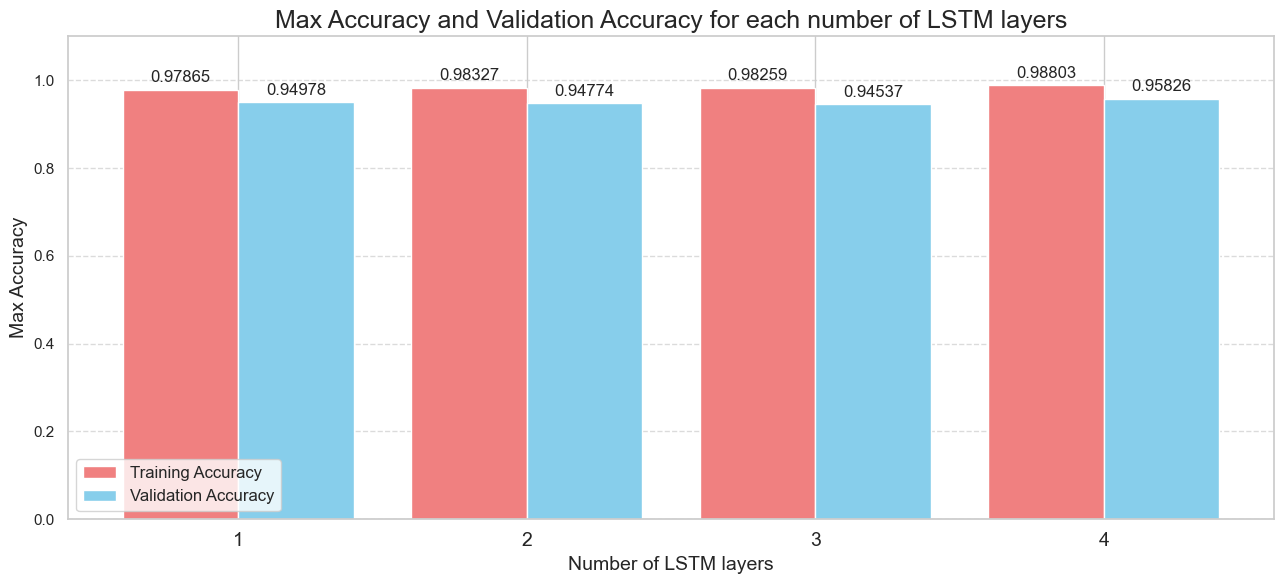

In [85]:
max_accuracies_1 = []
max_val_accuracies_1 = []

for history in model_history_list_1:
    # Lấy giá trị lớn nhất của accuracy và val_accuracy
    max_accuracy = max(history.history['accuracy'])
    max_val_accuracy = max(history.history['val_accuracy'])
    max_accuracies_1.append(max_accuracy)
    max_val_accuracies_1.append(max_val_accuracy)

sns.set(style="whitegrid")

# Vẽ biểu đồ
x_labels = [str(n) for n in number_LayerLSTM_List]  # Chuyển số lượng layer thành chuỗi để hiển thị
x_indices = np.arange(len(x_labels))  # Tạo vị trí cho các cột

width = 0.4  # Độ rộng của mỗi cột
plt.figure(figsize=(13, 6))

# Cột accuracy
plt.bar(x_indices - width/2, max_accuracies_1, width=width, label="Training Accuracy", color='lightcoral')

# Cột val_accuracy
plt.bar(x_indices + width/2, max_val_accuracies_1, width=width, label="Validation Accuracy", color='skyblue')

# Thiết lập trục X
plt.xticks(x_indices, x_labels, fontsize=14)
plt.title("Max Accuracy and Validation Accuracy for each number of LSTM layers", fontsize=18)
plt.xlabel("Number of LSTM layers", fontsize=14)
plt.ylabel("Max Accuracy", fontsize=14)
plt.ylim(0, 1.1)  # Giới hạn trục y nếu cần
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên các cột
for i, (x, acc, val_acc) in enumerate(zip(x_indices, max_accuracies_1, max_val_accuracies_1)):
    plt.text(x - width/2, acc + 0.01, f"{acc:.5f}", ha='center', va='bottom', fontsize=12)
    plt.text(x + width/2, val_acc + 0.01, f"{val_acc:.5f}", ha='center', va='bottom', fontsize=12)

# Hiển thị chú thích
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Nhận xét:
- Kết quả cao nhất: 0.95826
- Validation Accuracy cao nhất khi sử dụng 4 LSTM layers
- Có thể thấy Accuracy và Validation Accuracy tăng khi số lượng LSTM layers tăng.

In [101]:
model_list_1[3].summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 1, 64)             160256    
                                                                 
 lstm_50 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_51 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_52 (LSTM)              (None, 1, 64)             33024     
                                                                 
 dropout_23 (Dropout)        (None, 1, 64)             0         
                                                                 
 dense_46 (Dense)            (None, 1, 64)             4160      
                                                                 
 dense_47 (Dense)            (None, 1, 6)            

## Experiment 2: Test number of units in LSTM layer

In [80]:
def build_lstm_model(input_shape, output_shape, number_UnitsLSTM):
    model = Sequential()
    for i in range (4):
        model.add(LSTM(number_UnitsLSTM, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.3))
    model.add(Dense(number_UnitsLSTM, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

def train_lstm_model(X_train, Y_train, X_val, Y_val, number_UnitsLSTM, batch_size=32, epochs=10):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), len(np.unique(Y_train)),number_UnitsLSTM)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
    return model, history

In [81]:
# Train LSTM model
epochs = 50
number_UnitsLSTM_List = [32, 64, 128, 256]
model_list_2 = []
model_history_list_2 = []
base_dir_model = "Experiment_Tracking_LSTM/models"
bar_dir_history = "Experiment_Tracking_LSTM/history_models"

for number_UnitsLSTM in number_UnitsLSTM_List:
    model, history = train_lstm_model(X_train, y_train, X_test, y_test, epochs=epochs, number_UnitsLSTM=number_UnitsLSTM)
    model_list_2.append(model)
    model_history_list_2.append(history)
    model_name = "Exp2_LSTM"
    sub_model_name = f"number_Units_{number_UnitsLSTM}"
    save_model(model, history, base_dir_model, bar_dir_history, model_name, sub_model_name)



Epoch 1/50
230/230 [==============================] - 9s 11ms/step - loss: 1.3111 - accuracy: 0.3356 - val_loss: 1.1153 - val_accuracy: 0.3505
Epoch 2/50
230/230 [==============================] - 2s 7ms/step - loss: 1.0895 - accuracy: 0.3711 - val_loss: 1.0235 - val_accuracy: 0.4228
Epoch 3/50
230/230 [==============================] - 2s 8ms/step - loss: 0.9406 - accuracy: 0.4729 - val_loss: 0.8883 - val_accuracy: 0.4727
Epoch 4/50
230/230 [==============================] - 2s 7ms/step - loss: 0.8570 - accuracy: 0.5261 - val_loss: 0.7889 - val_accuracy: 0.6373
Epoch 5/50
230/230 [==============================] - 1s 7ms/step - loss: 0.6084 - accuracy: 0.6496 - val_loss: 0.6329 - val_accuracy: 0.6430
Epoch 6/50
230/230 [==============================] - 2s 7ms/step - loss: 0.5330 - accuracy: 0.6644 - val_loss: 0.6723 - val_accuracy: 0.6332
Epoch 7/50
230/230 [==============================] - 1s 6ms/step - loss: 0.5210 - accuracy: 0.6749 - val_loss: 0.6070 - val_accuracy: 0.6308
Epoch

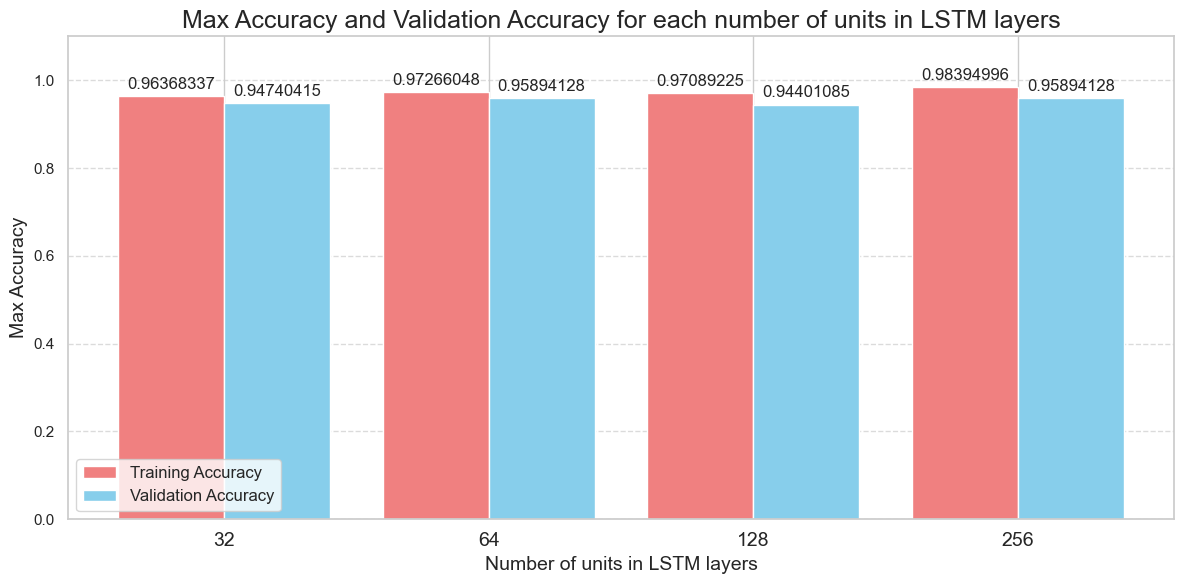

In [93]:
max_accuracies_2 = []
max_val_accuracies_2 = []

for history in model_history_list_2:
    # Lấy giá trị lớn nhất của accuracy và val_accuracy
    max_accuracy = max(history.history['accuracy'])
    max_val_accuracy = max(history.history['val_accuracy'])
    max_accuracies_2.append(max_accuracy)
    max_val_accuracies_2.append(max_val_accuracy)

sns.set(style="whitegrid")

# Vẽ biểu đồ
x_labels = [str(n) for n in number_UnitsLSTM_List]  # Chuyển số lượng layer thành chuỗi để hiển thị
x_indices = np.arange(len(x_labels))  # Tạo vị trí cho các cột

width = 0.4  # Độ rộng của mỗi cột
plt.figure(figsize=(12, 6))

# Cột accuracy
plt.bar(x_indices - width/2, max_accuracies_2, width=width, label="Training Accuracy", color='lightcoral')

# Cột val_accuracy
plt.bar(x_indices + width/2, max_val_accuracies_2, width=width, label="Validation Accuracy", color='skyblue')

# Thiết lập trục X
plt.xticks(x_indices, x_labels, fontsize=14)
plt.title("Max Accuracy and Validation Accuracy for each number of units in LSTM layers", fontsize=18)
plt.xlabel("Number of units in LSTM layers", fontsize=14)
plt.ylabel("Max Accuracy", fontsize=14)
plt.ylim(0, 1.1)  # Giới hạn trục y nếu cần
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên các cột
for i, (x, acc, val_acc) in enumerate(zip(x_indices, max_accuracies_2, max_val_accuracies_2)):
    plt.text(x - width/2, acc + 0.01, f"{acc:.8f}", ha='center', va='bottom', fontsize=12)
    plt.text(x + width/2, val_acc + 0.01, f"{val_acc:.8f}", ha='center', va='bottom', fontsize=12)

# Hiển thị chú thích
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Nhận xét:
- Kết quả cao nhất: 0.95894
- Validation Accuracy cao nhất khi sử dụng 256 hoặc 64 units trong LSTM layer

In [100]:
model_list_2[3].summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (None, 1, 256)            837632    
                                                                 
 dropout_45 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_92 (LSTM)              (None, 1, 256)            525312    
                                                                 
 dropout_46 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_93 (LSTM)              (None, 1, 256)            525312    
                                                                 
 dropout_47 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_94 (LSTM)              (None, 1, 256)          

## Experiment 3: Test using Bidirectional LSTM

In [86]:
def build_lstm_model(input_shape, output_shape):
    model = Sequential()
    # Thêm Bidirectional vào lớp LSTM thứ nhất
    for i in range(4):
        model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape))
        model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

def train_lstm_model(X_train, Y_train, X_val, Y_val, batch_size=32, epochs=10):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), len(np.unique(Y_train)))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
    return model, history



Epoch 1/50
230/230 [==============================] - 60s 225ms/step - loss: 0.7384 - accuracy: 0.6230 - val_loss: 0.4406 - val_accuracy: 0.8073
Epoch 2/50
230/230 [==============================] - 13s 58ms/step - loss: 0.2930 - accuracy: 0.8773 - val_loss: 0.2440 - val_accuracy: 0.9196
Epoch 3/50
230/230 [==============================] - 20s 87ms/step - loss: 0.1969 - accuracy: 0.9197 - val_loss: 0.3164 - val_accuracy: 0.8809
Epoch 4/50
230/230 [==============================] - 11s 50ms/step - loss: 0.1522 - accuracy: 0.9448 - val_loss: 0.2318 - val_accuracy: 0.9226
Epoch 5/50
230/230 [==============================] - 12s 50ms/step - loss: 0.1265 - accuracy: 0.9538 - val_loss: 0.1935 - val_accuracy: 0.9325
Epoch 6/50
230/230 [==============================] - 13s 56ms/step - loss: 0.1167 - accuracy: 0.9554 - val_loss: 0.1721 - val_accuracy: 0.9403
Epoch 7/50
230/230 [==============================] - 23s 101ms/step - loss: 0.0970 - accuracy: 0.9653 - val_loss: 0.2030 - val_accurac

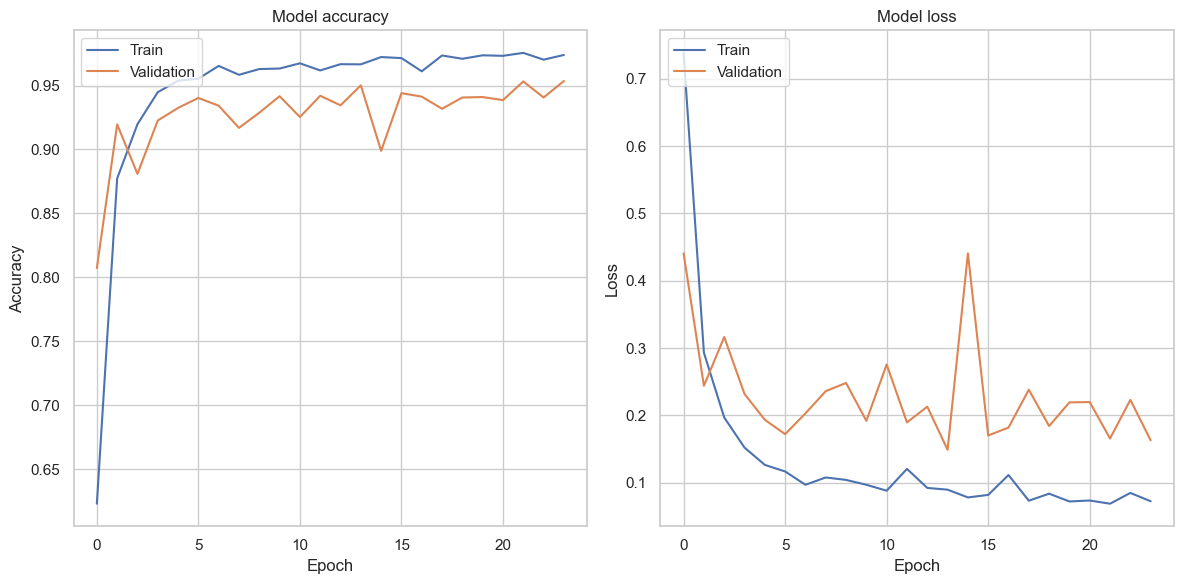

In [87]:
# X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train LSTM model
epochs = 50
lstm_model, lstm_history = train_lstm_model(X_train, y_train, X_test, y_test, epochs = epochs)

# Plot training and validation curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [88]:
lstm_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 1, 512)           1675264   
 nal)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 1, 512)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 1, 512)           1574912   
 nal)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 1, 512)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 512)           1574912   
 nal)                                                            
                                                     

In [89]:
print("Training Accuracy: ", max(lstm_history.history['accuracy']))
print("Validation Accuracy: ", max(lstm_history.history['val_accuracy']))

Training Accuracy:  0.9755168557167053
Validation Accuracy:  0.9535120725631714


In [90]:
base_dir_model = "Experiment_Tracking_LSTM/models"
bar_dir_history = "Experiment_Tracking_LSTM/history_models"
model_name = "Exp3_LSTM"
sub_model_name = "Bidirectional"
save_model(lstm_model, lstm_history, base_dir_model, bar_dir_history, model_name, sub_model_name)

Model saved to: Experiment_Tracking_LSTM/models\model_Exp3_LSTM_Bidirectional.h5
Model history saved to: Experiment_Tracking_LSTM/history_models\history_Exp3_LSTM_Bidirectional.pkl


Training Accuracy:  0.9755168557167053

Validation Accuracy:  0.9535120725631714

### Nhận xét:
- Kết quả đạt được thấp hơn khi không sử dụng Bidirectional LSTM
- Nguyên nhân có thể do Bidirectional LSTM gây nhiễu

(Bidirectional LSTM: mô hình sẽ không chỉ học từ quá khứ mà còn từ tương lai (chuỗi ngược), điều này làm mất đi tính causal relationship giữa dữ liệu và dự báo)

## Kết luận: 
- Có thể sử dụng 2 kết quả tốt nhất từ Experiment 2: 
    - 256 units trong 4 LSTM layers
    - 64 units trong 4 LSTM layers

In [76]:
# from sklearn.metrics import precision_score, recall_score, f1_score
# 
# def evaluate_model(model, X_test, Y_test):
#     Y_pred_prob = model.predict(X_test)
#     Y_pred = np.argmax(Y_pred_prob, axis=1)
# 
#     # Accuracy
#     testing_accuracy = accuracy_score(Y_test, Y_pred)
#     print("Testing Accuracy:", testing_accuracy)
# 
#     # # Precision, Recall, F1-score
#     # precision = precision_score(Y_test, Y_pred, average='weighted')
#     # recall = recall_score(Y_test, Y_pred, average='weighted')
#     # f1 = f1_score(Y_test, Y_pred, average='weighted')
#     # 
#     # print("Precision:", precision)
#     # print("Recall:", recall)
#     # print("F1 Score:", f1)
# 
#     # Confusion Matrix
#     conf_matrix = confusion_matrix(Y_test, Y_pred)
# 
#     # Normalize confusion matrix
#     conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# 
#     # Display confusion matrix as heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(conf_matrix_norm, annot=True, fmt='.2%', cmap='Blues',
#                 xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
#     plt.xlabel('Predicted labels')
#     plt.ylabel('True labels')
#     plt.title('Normalized Confusion Matrix')
#     plt.show()
# 
#     return testing_accuracy, precision, recall, f1, conf_matrix
# 
# # Evaluate LSTM model
# testing_accuracy, precision, recall, f1, conf_matrix = evaluate_model(lstm_model, X_test_reshaped, Y_test_encoded)
